# เทอร์โมไดนามิกส์ไดอะแกรม

ใช้คำสั่ง conda activate metpy

* เทอร์โมไดนามิกส์ไดอะแกรมสามารถนำไปใช้ศึกษาสภาพอากาศที่รุนแรง เช่น พายุลูกเห็บ พายุฤดูร้อน พายุฝนฟ้าคะนอง 
* ดังนั้นไดอะแกรม skew-T/logP  จึงมีความสำคัญมากต่อการวิเคราะห์ลักษณะทางกายภาพของบรรยากาศที่เอื้อให้เกิดสภาวะอากาศที่รุนแรง
* นิสิตสามารถนำผลที่ได้จากการวิเคราะห์เทอร์โมไดนามิกส์มาร่วมวิเคราะห์กับข้อมูลรีโมทเซนซิ่ง เช่น เรดาร์ตรวจอากาศและดาวเทียมอินฟราเรดในช่วงอากาศที่รุนแรงได้

ยูทูปชาแนลและแหล่งเรียนรู้ออนไลน์ที่นิสิตควรศึกษาทางด้านบรรยากาศศาสตร์ ได้แก่
* Dr.kevin Perry จากมหาวิทยาลัย Utah สอนเรื่องบรรยากาศศาสตร์ https://www.youtube.com/channel/UCktw_bKshmipG9QH_pgMkLw/videos
* Prof.Dr.Ronald Smith จากมหาวิทยาลัยYale เรื่องThe Atmosphere, the Ocean, and Environmental Change  https://oyc.yale.edu/geology-and-geophysics/gg-140
* หนังสือฟรี อุตุนิยมวิทยาภาคปฏิบัติ สอนการคำนวณของ Prof.Roland Stull https://www.eoas.ubc.ca/books/Practical_Meteorology/
* คำอธิบายพารามิเตอร์ของ Severe storm จาก SPC https://www.spc.noaa.gov/exper/mesoanalysis/help/begin.html
* การแปลผลค่าดัชนี severe storm จาก weather.gov https://www.weather.gov/lmk/indices และ https://en.wikipedia.org/wiki/Atmospheric_instability


## 1.การพลอต skew-T/logP 
จากเวป metpy ยูทูป  https://www.youtube.com/watch?v=oog6_b-844Q&list=PLQut5OXpV-0ir4IdllSt1iEZKTwFBa7kO&index=11
ลิงก์พลอตตัวอย่าง https://unidata.github.io/MetPy/latest/examples/plots/Hodograph_Inset.html

In [1]:
from datetime import datetime #datetime object
from siphon.simplewebservice.wyoming import WyomingUpperAir
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from metpy.units import units
from metpy.calc import wind_components
import metpy.plots as plots
import metpy.calc as mpcalc
from metpy.plots import Hodograph
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
df = pd.read_csv('./0output/era5_23042020_1100utc_wyoming.txt', delim_whitespace=True, skiprows=[0, 1, 2, 3, 4, 5], 
            names=["pressure", "height", "temperature", "dewpoint", "RELH", "MIXR", "DRCT", "SKNT", "THTA", "THTE", "THT" ] )
#df = df.drop([35, 36, 37])

In [3]:
# ลบแถวที่พบว่ามีช่องใดก็ตามที่เป็นค่า NAN -Drop any rows with all NaN values for T, Td, winds
df = df.dropna(subset=("pressure", "height", "temperature", "dewpoint", "RELH", "MIXR", "DRCT", "SKNT", "THTA", "THTE", "THT"
                       ), how='any').reset_index(drop=True)

In [4]:
#คำนวณ u และ v from direction & speed
wspd = df['SKNT'].values * units('knot').to('m/s') 
wdir = df['DRCT'].values * units('deg')
u,v = wind_components(wspd, wdir)

In [5]:
# เก็บค่าอื่นๆ ที่ต้องใช้ในการพลอตค่า sounding ใน skew-T/log P ไดอะแกรม
p = df['pressure'].values * units('hPa')
T = df['temperature'].values * units('degC')
Td = df['dewpoint'].values * units('degC')
height = df['height'].values * units('m')

## 2. พลอตแบบ resampling ลูกศรลมแบบ non-linear หรือ log scale

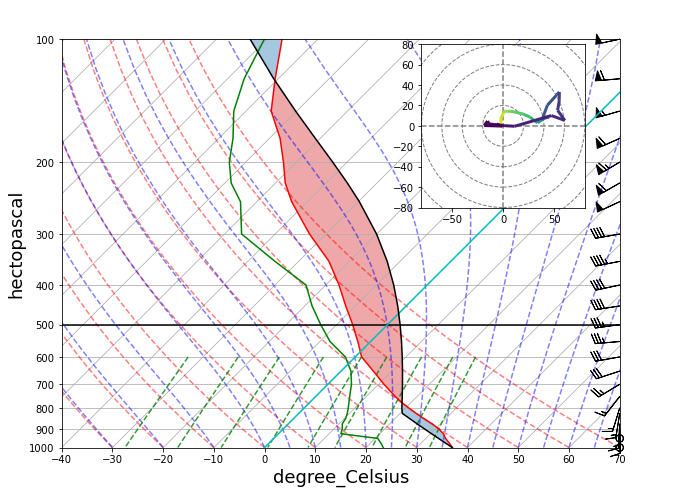

In [6]:
## พลอตแบบ resampling ลูกศรลมแบบ non-linear หรือ log scale
p = p.astype(float)
# กำหนดระยะที่ต้องการให้ลูกศรลมแสดง
interval = np.logspace(2, 3) * units.hPa 
idx = mpcalc.resample_nn_1d(p, interval)

fig = plt.figure(figsize=(10,10))
#skew = plots.SkewT(fig)
skew = plots.SkewT(fig, rotation=45)

# พลอตความกดอากาศและอุณหภูมิ
skew.plot(p, T, 'red')

# พลอต Td หรือ อุณหภูมิจุดน้ำค้าง
skew.plot(p, Td, 'green')

skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 70)

# พลอต wind barbs ในแกน y ข้างขวา
skew.plot_barbs(p[idx], u[idx], v[idx]) #พลอตลมตามอินเด็กซ์ที่ได้ทำการ resample

# พลอต dry adiabatic
skew.plot_dry_adiabats()

# พลอต moist adiabatic
skew.plot_moist_adiabats()

# พลอต mixing ratio
skew.plot_mixing_lines()

# เพิ่มเส้นหรือเน้นเส้นความกดอากาศพิเศษ เช่น ที่ระดับ 500 hPa
skew.ax.axhline(500 * units.hPa, color='k')

# เน้นเส้นอุณหภูมิที่ระดับ freezing level หรือ 0 celsius 
skew.ax.axvline(0* units.degC, color='c')

# หาค่า Parcel path CAPE/CIN 
T = T.astype(float)
Td = Td.astype(float)
mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
parcel_path = mpcalc.parcel_profile(p, T[0], Td[0])
skew.plot(p, parcel_path, color='k')

# ทำการแรเงาพื้นที่ CAPE
skew.shade_cape(p, T, parcel_path)

# ทำการแรเงาพื้นที่ CIN
skew.shade_cin(p, T,  parcel_path)

# เซตค่าฟอนท์
#plt.rcParams['font.family'] = "sans-serif"
plt.xlabel('degree_Celsius', fontsize=18)
plt.ylabel('hectopascal', fontsize=18)

# สร้าง hodograph
ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1)
h = Hodograph(ax_hod, component_range=80.)
h.add_grid(increment=20)
h.plot_colormapped(u, v, p) #p

plt.savefig( './0output/fig6d.jpg', dpi=300)
plt.show()


เส้นสีดำแสดงของ parcel path ที่ยกตัวขึ้นไปในบรรยากาศด้านบน ที่ต้องแรกยกตัวตามเส้น dry adiabatic lapse rate 
และเมื่อถึงจุดที่เกิดการกลั่นตัวหรือ ฐานเมฆในที่นี้เรียกว่าระดับ LCL (Lifting condensation level) จึงเกิดการยกตัวขึ้นไป ตามเส้นของ moist adiabatic lapse rate 
ที่มีการลดลงของอุณหภูมิตามความสูงที่น้อยกว่าเมื่อเทียบกับ dry adiabatic lapse rate โดยก้อนอากาศจะยกตัวไปจนถึง equilibrium level หรือ EL

พื้นที่ระหว่างเส้นสีแดงที่เป็นอุณหภูมิของก้อนอากาศหรือ parcel กับเส้นสีดำ แสดงถึงพลังงานที่มีอยู่ของก้อนอากาศที่จะสามารถยกตัวขึ้นไปได้
ในที่นี้คือ CAPE หรือ Convective available potential energy หากมีพื้นที่มากแสดงว่ามีค่า CAPE ที่มาก มักแสดงถึงสภาวะของบรรยกาศที่สนับสนุนให้เกิดเมฆฝนฟ้าคะนอง
ที่รุนแรงขึ้นมาได้

    * ศึกษาเรื่อง CAPE ได้จาก Dr.Kevin Perry https://www.youtube.com/watch?v=jCfjZ4jJGT0
    * ศึกษาเรือง LCL ได้จาก Dr.Kevin Perry  https://www.youtube.com/watch?v=J9VUUZPMpbw

CIN (Convective inhibition) หรือ  เป็นอีกพื้นที่หนึ่งที่แสดงถึง ค่าพลังงานที่ไม่ยอมให้ก้อนอากาศเกิดการยกตัว อ่าน https://en.wikipedia.org/wiki/Convective_inhibition

สังเกตุว่ามี CIN อยู่สองบริเวณ นั่นคือในช่วงต้นของชั้นบรรยากาศและช่วงปลาย เนื่องจากเส้นสีดำ ที่แสดงถึงอุณหภูมิของก้อนอากาศมีค่าอัตราการลดลงหรือ lapse rate ที่น้อยกว่าหรือต่ำกว่าอุณหภูมิของสิ่งแวดล้อมหรือ T ทำให้เกิดสภาวะเสถียรภาพของบรรยากาศ หรือ stable ก้อนอากาศในช่วงระดับความกดดังกล่าวจึงมีลักษณะการจมตัวลงมา 

## คำนวณค่าพารามิเตอร์ asmospheric instability 
CAPE CIN CCL  LCL LI K Showalter_index SFC ML MUCAPE DCAPE SBCAPE DOWNT MBURST SHEAR SFC

ศึกษาการแปลผลจาก https://www.weather.gov/lmk/indices และ https://www.spc.noaa.gov/exper/mesoanalysis/help/begin.html และ https://en.wikipedia.org/wiki/Atmospheric_instability

In [7]:
# คำนวณค่า shear ในระดับต่ำ https://unidata.github.io/MetPy/dev/examples/calculations/Bulk_Shear.html
height= height.astype(float)
print(mpcalc.bulk_shear(p, u, v, height, depth=3 * units.km, bottom=height[0]))

(<Quantity(19.6772749, 'meter / second')>, <Quantity(11.1436766, 'meter / second')>)


In [8]:
# คำนวณ LCL https://www.youtube.com/watch?v=kGljsludKtk
mpcalc.lcl(p[0], T[0], Td[0])

(822.6932547775394 <Unit('hectopascal')>,
 20.187816944909684 <Unit('degree_Celsius')>)

In [9]:
mpcalc.lfc(p, T, Td)

(776.5903883599246 <Unit('hectopascal')>,
 18.25271622957338 <Unit('degree_Celsius')>)

In [10]:
mpcalc.el(p, T, Td)

(126.26941188564614 <Unit('hectopascal')>,
 -70.31020784556235 <Unit('degree_Celsius')>)

In [11]:
#คำนวณ parcel path
prof=parcel_path.to('degC')
mpcalc.el(p, T, Td, prof)

(126.26941188564614 <Unit('hectopascal')>,
 -70.31020784556235 <Unit('degree_Celsius')>)

### คำนวณดัชนี severe storm จาก Indices used for asmospheric instability

In [12]:
#https://www.youtube.com/watch?v=EJfsaPjQ1RU&t=315s
# คำนวณค่า CAPE
mpcalc.cape_cin(p, T, Td, parcel_path)

(4544.18520576188 <Unit('joule / kilogram')>,
 -140.04747575113407 <Unit('joule / kilogram')>)

In [13]:
# คำนวณค่า CAPE 6 กิโลเมตร
ps, Ts, Tds=mpcalc.get_layer(p, T, Td, height=height, depth=6 * units.km)
mpcalc.surface_based_cape_cin(ps, Ts, Tds)

(830.9972047411061 <Unit('joule / kilogram')>,
 -140.59956511385968 <Unit('joule / kilogram')>)

In [14]:
# ค่า LI https://en.wikipedia.org/wiki/Lifted_index
mpcalc.lifted_index(p, T, parcel_path)

Magnitude,[-9.350339379339058]
Units,delta_degree_Celsius


In [15]:
#ค่า KI
mpcalc.k_index(p, T, Td)

36.46000000000001 <Unit('degree_Celsius')>

In [16]:
# ค่า TTI
mpcalc.total_totals_index(p, T, Td)

49.74 <Unit('delta_degree_Celsius')>

In [17]:
# ค่า SI
mpcalc.showalter_index(p, T, Td)

Magnitude,[-0.8735810989363655]
Units,delta_degree_Celsius


### สิ่งที่นิสิตควรศึกษา

การนำเทอร์โมไดนามิกส์ไดอะแกรมนี้ไปใช้ศึกษาสภาพอากาศที่รุนแรง เช่น พายุลูกเห็บ พายุฤดูร้อน พายุฝนฟ้าคะนอง จำเป็นที่จะต้องศึกษาหลักการคิด หลักการคำนวณค่าพารามิเตอร์ดังต่อไปนี้

* การคำนวณค่า LCL, LFC, EL จากลิงก์ยูทูป metpy monday https://www.youtube.com/watch?v=kGljsludKtk&list=PLQut5OXpV-0ir4IdllSt1iEZKTwFBa7kO&index=16
    
* การคำนวณค่า CAPEและค่า CIN จากลิงก์ยูทูป metpy monday https://www.youtube.com/watch?v=EJfsaPjQ1RU&list=PLQut5OXpV-0ir4IdllSt1iEZKTwFBa7kO&index=17

* สอนการทำ Hodograph เพื่อวิเคราะห์ windshear จากลิงก์ยูทูป metpy monday https://www.youtube.com/watch?v=c0Uc7imDNv0&list=PLQut5OXpV-0ir4IdllSt1iEZKTwFBa7kO&index=32
    
### code ไดอะแกรม skew-T/logP ที่มี Hodograph ที่แสดงทิศทางและความเร็วลมในแต่ละระดับ
* จาก metpy เวป https://unidata.github.io/MetPy/latest/examples/plots/Skew-T_Layout.html#
* อีกรูปแบบของ hodograph ใน skew-T/logP จาก metpy เวป  https://unidata.github.io/MetPy/latest/examples/plots/Hodograph_Inset.html
* โค้ดพลอต sounding อย่างง่าย https://unidata.github.io/MetPy/latest/examples/plots/Simple_Sounding.html

## งานมอบหมายนิสิต
1. ค้นหาข่าวพายุฤดูร้อนหรือพายุลูกเห็บในเชียงใหม่ เพื่อระบุวันที่มีเหตุการณ์รุนแรงดังกล่าว ให้นิสิตหาอย่างน้อยทั้งสองวัน
2. พลอต skew-T/ logP เพื่อดูค่าเทอร์โมไดนามิกส์ CAPE/CIN/LCL/LFC/EL
3. เปรียบเทียบค่า CAPE/CIN/LCL/LFC/EL ด้วยสายตา ของเหตุการณ์ทั้งสองวันที่เลือกมา ว่าวันไหนมีความรุนแรงมากกว่ากัน